In [7]:
# Import libraries
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import itertools
import argparse
import sys
import time
from sklearn import preprocessing
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'

In [8]:
## Preprocessing of data
# Function to load data

def get_power_data():
    """
    Read the Individual household electric power consumption dataset
    """
    
    # Assume that the dataset is located on folder "data"
    data = pd.read_csv('household_power_consumption.txt',
                       sep=';', low_memory=False)

    # Drop some non-predictive variables
    data = data.drop(columns=['Date', 'Time'], axis=1)

    #print(data.head())

    # Replace missing values
    data = data.replace('?', np.nan)

    # Drop NA
    data = data.dropna(axis=0)

    # Normalize
    standard_scaler = preprocessing.StandardScaler()
    np_scaled = standard_scaler.fit_transform(data)
    data = pd.DataFrame(np_scaled)

    # Goal variable assumed to be the first
    X = data.values[:, 1:].astype('float32')
    y = data.values[:, 0].astype('float32')

    # Create categorical y for binary classification with balanced classes
    y = np.sign(y+0.46)

    # Split train and test data here: (X_train, Y_train, X_test, Y_test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    no_class = 2                 #binary classification

    return X_train, X_test, y_train, y_test, no_class

In [9]:
X_train, X_test, y_train, y_test, no_class = get_power_data()
print("X,y types: {} {}".format(type(X_train), type(y_train)))
print("X size {}".format(X_train.shape))
print("Y size {}".format(y_train.shape))

# Create a binary variable from one of the columns.
# You can use this OR not

idx = y_train >= 0
notidx = y_train < 0
y_train[idx] = 1
y_train[notidx] = -1

X,y types: <class 'numpy.ndarray'> <class 'numpy.ndarray'>
X size (1536960, 6)
Y size (1536960,)


In [10]:
# Sigmoid function
def sigmoid(x, derivative=False):
    sigm = 1. / (1. + np.exp(-x))
    if derivative:
        return sigm * (1. - sigm)
    return sigm

# Define weights initialization
def initialize_w(N, d):
    return 2*np.random.random((N,d)) - 1

In [11]:
# Fill in feed forward propagation
def feed_forward_propagation(X, y, w_1, w_2, w_3, lmbda):
    # Fill in
    layer_0 = X.T     
    layer_1 = sigmoid(np.dot(w_1.T,layer_0))
    layer_2 = sigmoid(np.dot(w_2.T,layer_1))  
    layer_3 = np.dot(w_3.T,layer_2) 
    return layer_0, layer_1, layer_2, layer_3

In [12]:
## Fill in backpropagation    
def back_propagation(y, w_1, w_2, w_3, layer_0, layer_1, layer_2, layer_3):
    # Calculate the gradient here
    # Compute the error
    d_layer_3 = layer_3 - y.reshape(1,y.shape[0]) 
    d_layer_2 = np.dot(w_3, d_layer_3) * layer_2 * (1 - layer_2) 
    d_layer_1 = np.dot(w_2, d_layer_2) * layer_1 * (1 - layer_1)
    
    # Compute the gradients of the weights
    layer_3_delta = np.dot(layer_2, d_layer_3.T)
    layer_2_delta = np.dot(layer_1, d_layer_2.T) 
    layer_1_delta = np.dot(layer_0, d_layer_1.T) 
    
    return layer_1_delta, layer_2_delta, layer_3_delta 

In [13]:
# Cost function
def cost(X, y, w_1, w_2, w_3, lmbda):
    N, d = X.shape
    a1,a2,a3,a4 = feed_forward_propagation(X,y,w_1,w_2,w_3,lmbda)
    #regularization = (lmbda) * ((np.linalg.norm(w_1)** 2) +( np.linalg.norm(w_2) ** 2) + (np.linalg.norm(w_3)** 2))
    #return regularization + np.linalg.norm(a4[:,0] - y,2) ** 2 / N #with reqularization
    return np.linalg.norm(a4[:,0] - y,2) ** 2 / N  #without regularization
    

In [14]:
def SGD(X, y, w_1, w_2, w_3, lmbda, learning_rate, batch_size):
    N = X.shape[0]
    data_index = np.random.choice(N, batch_size)  #Random choose the data i, using batch from [i,i+batch_size-1]
           
    
    X_batch = X[data_index, :]
    y_batch = y[data_index]
        
    # Forward pass
    layer_0, layer_1, layer_2, layer_3 = feed_forward_propagation( X_batch, y_batch, w_1, w_2, w_3, lmbda)
        
    # Backward pass
    d_w_1, d_w_2, d_w_3 = back_propagation(y_batch, w_1, w_2, w_3, layer_0, layer_1, layer_2, layer_3)
    
        
    w_3 -= learning_rate * (d_w_3 + lmbda * w_3 / N)
    w_2 -= learning_rate * (d_w_2 + lmbda * w_2 / N)
    w_1 -= learning_rate * (d_w_1 + lmbda * w_1 / N)

    return w_1, w_2, w_3

In [44]:
def SVRG(X, y, w_1, w_2, w_3, lmbda, learning_rate, batch_size, T):
    
    N = X.shape[0]
    m = int(N / batch_size)
    # Initialize weights
    w_3_last = w_3.copy()
    w_2_last = w_2.copy()
    w_1_last = w_1.copy()
    
    for t in range(T):
        # Full gradient
        layer_0, layer_1, layer_2, layer_3 = feed_forward_propagation(X, y, w_1_last, w_2_last, w_3_last, lmbda)
        layer_1_delta, layer_2_delta, layer_3_delta = back_propagation(y, w_1_last, w_2_last, w_3_last, layer_0, layer_1, layer_2, layer_3)

        # Randomly choose a data point from the batch
        for i in range(m):
            # Choose random data point from batch
            batch_indices = np.random.choice(N, batch_size)
            X_batch = X[batch_indices, :]
            y_batch = y[batch_indices]

            # Compute stochastic gradient
            c1, c2, c3, c4 = feed_forward_propagation(X_batch, y_batch, w_1_last, w_2_last, w_3_last, lmbda)
            grad_zeta_w_1_tilde, grad_zeta_w_2_tilde, grad_zeta_w_3_tilde = back_propagation(y_batch, w_1_last, w_2_last, w_3_last, c1, c2, c3, c4)

            # Compute full gradient at the same data point
            a1_zeta, a2_zeta, a3_zeta, a4_zeta = feed_forward_propagation(X_batch, y_batch, w_1_last, w_2_last, w_3_last, lmbda)
            layer_1_delta_zeta, layer_2_delta_zeta, layer_3_delta_zeta = back_propagation(y_batch, w_1_last, w_2_last, w_3_last, a1_zeta, a2_zeta, a3_zeta, a4_zeta)

            # Compute variance reduced gradient
            b1, b2, b3, b4 = feed_forward_propagation(X_batch, y_batch, w_1_last, w_2_last, w_3_last, lmbda)
            grad_zeta_w_1, grad_zeta_w_2, grad_zeta_w_3 = back_propagation(y_batch, w_1_last, w_2_last, w_3_last,b1, b2, b3, b4)   
            grad_w_3 = grad_zeta_w_3 - grad_zeta_w_3_tilde + layer_3_delta_zeta
            grad_w_2 = grad_zeta_w_2 - grad_zeta_w_2_tilde + layer_2_delta_zeta
            grad_w_1 = grad_zeta_w_1 - grad_zeta_w_1_tilde + layer_1_delta_zeta

            # Update weights
            w_3 -= learning_rate *  (grad_w_3 + lmbda * w_3)/N
            w_2 -= learning_rate * (grad_w_2 + lmbda * w_2)/N
            w_1 -= learning_rate * (grad_w_1 + lmbda * w_1)/N

        # Update last weights after each epoch
        w_3_last = w_3.copy()
        w_2_last = w_2.copy()
        w_1_last = w_1.copy()
    
    return w_1, w_2, w_3

In [16]:
# Define GD here:
def GD(X, y, w_1,w_2,w_3, learning_rate, lmbda):
    # Complete here:
    N = X.shape[0]
    # Forward pass
    layer_0, layer_1, layer_2, layer_3 = feed_forward_propagation(X, y, w_1, w_2, w_3, lmbda)       
    # Backward pass
    d_w_1, d_w_2, d_w_3 = back_propagation(y, w_1, w_2, w_3, layer_0, layer_1, layer_2, layer_3)
        
    w_3 -= learning_rate * (d_w_3 + lmbda * w_3)/N
    w_2 -= learning_rate * (d_w_2 + lmbda * w_2)/N
    w_1 -= learning_rate * (d_w_1 + lmbda * w_1)/N
    return w_1, w_2, w_3


In [17]:
# Define projected GD here:
def PGD(X, y, w_1,w_2,w_3, learning_rate, lmbda, noise):
    # Complete here:
     # Initialize weights
    N = X.shape[0]
    # Forward pass
    layer_0, layer_1, layer_2, layer_3 = feed_forward_propagation(X, y, w_1, w_2, w_3, lmbda)       
    # Backward pass
    d_w_1, d_w_2, d_w_3 = back_propagation(y, w_1, w_2, w_3, layer_0, layer_1, layer_2, layer_3)
     
    w_3 -= learning_rate * (d_w_3 + lmbda * w_3)/N + noise*np.random.randn(*w_3.shape)
    w_2 -= learning_rate * (d_w_2 + lmbda * w_2)/N + noise*np.random.randn(*w_2.shape)
    w_1 -= learning_rate * (d_w_1 + lmbda * w_1)/N + noise*np.random.randn(*w_1.shape)
    return w_1, w_2, w_3

In [18]:
# Define BCD here:
def BCD(X, y, w_1,w_2,w_3, learning_rate, lmbda):
    # Randomly choose one of w_1, w_2, w_3 to update
    N = X.shape[0]
    layer_0, layer_1, layer_2, layer_3 = feed_forward_propagation(X, y, w_1, w_2, w_3, lmbda)       
    # Backward pass
    d_w_1, d_w_2, d_w_3 = back_propagation(y, w_1, w_2, w_3, layer_0, layer_1, layer_2, layer_3)
    if np.random.choice(3)== 0:
        w_3 -= learning_rate  * (d_w_3 + lmbda * w_3)/N
    if np.random.choice(3)== 1:
        w_2 -= learning_rate  * (d_w_2 + lmbda * w_2)/N
    if np.random.choice(3)== 2:
        w_1 -= learning_rate  * (d_w_1 + lmbda * w_1)/N

    return w_1, w_2, w_3

In [45]:
y_train

array([ 1., -1.,  1., ...,  1.,  1., -1.], dtype=float32)

In [46]:
# Should be a hyperparameter that you tune, not an argument - Fill in the values
parser = argparse.ArgumentParser()

# Power
parser.add_argument('--lambda', type=float, default=1e-2, dest='lmbda') 
parser.add_argument('--w_size', type=int, default=50, dest='w_size')
parser.add_argument('--lr', type=float, default=1e-2)
parser.add_argument('--iterations', type=int, default=100)
args = parser.parse_args([])

#args, unknown_args = parser.parse_known_args()

In [47]:
def defineOptimizer(i, X_train, y_train, w_1, w_2, w_3, lmbda, lr, batch_size=16):
    if i == 0:
        optimizers = {# Fill in the hyperparameters
                        "opt": SGD(X_train, y_train, w_1, w_2, w_3, args.lmbda, args.lr, batch_size=16),
                        "name": "SGD",
                        #"inner": None
                     }
    elif i == 1:
        optimizers = {# Fill in the hyperparameters
                        "opt": SVRG(X_train, y_train, w_1, w_2, w_3, args.lmbda, args.lr,batch_size=16,T=4),
                        "name": "SVRG",
                        #"inner": None
                    }
    elif i == 2:
        optimizers = {# Fill in the hyperparameters
                        "opt": GD(
                            X_train, y_train, w_1, w_2, w_3, learning_rate=args.lr,
                            lmbda=args.lmbda),
                        "name": "GD",
                        #"inner": None
                     }       
    elif i == 3:
        optimizers = {# Fill in the hyperparameters
                        "opt": PGD(
                            X_train, y_train, w_1, w_2, w_3, learning_rate=args.lr,
                            lmbda=args.lmbda, noise=1e-3),
                        "name": "PGD",
                        #"inner":None
                    }
    elif i == 4:
        optimizers = {# Fill in the hyperparameters
                        "opt": BCD(
                            X_train, y_train, w_1, w_2, w_3, learning_rate=args.lr,
                            lmbda=args.lmbda),
                        "name": "BCD",
                        #"inner": None
                    }
    return optimizers

In [48]:
# Initialize weights
#w_1 = initialize_w(X_train.shape[1], args.w_size)
#w_2 = initialize_w(args.w_size,args.w_size)
#w_3 = initialize_w(args.w_size, 1)

# Get iterations
iterations = args.iterations


In [42]:
# Run the iterates over the algorithms above
loss_= np.zeros((iterations,5))
ti= np.zeros((iterations,5))
algoNames = ['SGD', 'SVRG', 'GD', 'PGD', 'BCD']

In [59]:

i=0
print("Running {}".format(algoNames[i]))
# initialize weights
w_1 = initialize_w(X_train.shape[1], args.w_size)
w_2 = initialize_w(args.w_size,args.w_size)
w_3 = initialize_w(args.w_size, 1)

for j in range(iterations):
    print("......",j,".......")
    start = time.time() 
    optimizers = defineOptimizer(i, X_train, y_train, w_1, w_2, w_3, args.lmbda, args.lr)
    end = time.time()
    loss_[j,i] = cost(X_train, y_train, w_1, w_2, w_3, args.lmbda)
    ti[j,i] = end-start
    print("......",loss_[j,i],".......")
    

Running SGD
...... 0 .......
...... 56.46027697475826 .......
...... 1 .......
...... 163.91462797092308 .......
...... 2 .......
...... 122.49368781465586 .......
...... 3 .......
...... 2.7498753382993684 .......
...... 4 .......
...... 2.1148537457614736 .......
...... 5 .......
...... 1.21860518087522 .......
...... 6 .......
...... 1.0294934942020668 .......
...... 7 .......
...... 1.0917609586467836 .......
...... 8 .......
...... 1.0555748415996022 .......
...... 9 .......
...... 1.103825726886375 .......
...... 10 .......
...... 1.0845586368200637 .......
...... 11 .......
...... 1.1056206677932812 .......
...... 12 .......
...... 1.0738424869337495 .......
...... 13 .......
...... 1.0578268316805313 .......
...... 14 .......
...... 1.0432472952243774 .......
...... 15 .......
...... 1.050117073449813 .......
...... 16 .......
...... 1.0197018749385725 .......
...... 17 .......
...... 1.006704879883306 .......
...... 18 .......
...... 1.0123768445367682 .......
...... 19 ......

In [72]:
i=1
algoNames = ['SGD', 'SVRG', 'GD', 'PGD', 'BCD']
print("Running {}".format(algoNames[i]))
# initialize weights
w_1 = initialize_w(X_train.shape[1], args.w_size)
w_2 = initialize_w(args.w_size,args.w_size)
w_3 = initialize_w(args.w_size, 1)

for j in range(iterations):
    print("......",j,".......")
    start = time.time() 
    optimizers = defineOptimizer(i, X_train, y_train, w_1, w_2, w_3, args.lmbda, 10*args.lr)
    end = time.time()
    loss_[j,i] = cost(X_train, y_train, w_1, w_2, w_3, args.lmbda)
    ti[j,i] = end-start
    print("......",loss_[j,i],".......")


Running SVRG
...... 0 .......
...... 5.801811129491061 .......
...... 1 .......
...... 1.7658362959932774 .......
...... 2 .......
...... 1.1169195695189478 .......
...... 3 .......
...... 1.0145096623392247 .......
...... 4 .......
...... 1.0005854817730915 .......
...... 5 .......
...... 1.0004500243277963 .......
...... 6 .......
...... 1.0021356254273026 .......
...... 7 .......
...... 1.0038528853734017 .......
...... 8 .......
...... 1.0055141754174475 .......
...... 9 .......
...... 1.0071339404873203 .......
...... 10 .......
...... 1.008896029596423 .......
...... 11 .......
...... 1.0107052573301982 .......
...... 12 .......
...... 1.0125423043455664 .......
...... 13 .......
...... 1.014365307755677 .......
...... 14 .......
...... 1.0162139537101114 .......
...... 15 .......
...... 1.0181502449418147 .......
...... 16 .......
...... 1.02001294498781 .......
...... 17 .......
...... 1.0219385136701937 .......
...... 18 .......
...... 1.0238748054994056 .......
...... 19 ....

In [57]:
i=2
print("Running {}".format(algoNames[i]))
# initialize weights
w_1 = initialize_w(X_train.shape[1], args.w_size)
w_2 = initialize_w(args.w_size,args.w_size)
w_3 = initialize_w(args.w_size, 1)

for j in range(iterations):
    print("......",j,".......")
    start = time.time() 
    optimizers = defineOptimizer(i, X_train, y_train, w_1, w_2, w_3, args.lmbda, args.lr)
    end = time.time()
    loss_[j,i] = cost(X_train, y_train, w_1, w_2, w_3, args.lmbda)
    ti[j,i] = end-start
    print("......",loss_[j,i],".......")
    

Running GD
...... 0 .......
...... 11.688688826434522 .......
...... 1 .......
...... 7.896676441280257 .......
...... 2 .......
...... 5.51375704390067 .......
...... 3 .......
...... 4.005435378565351 .......
...... 4 .......
...... 3.0426199929592954 .......
...... 5 .......
...... 2.4219425261308567 .......
...... 6 .......
...... 2.0172896116846695 .......
...... 7 .......
...... 1.750148829463243 .......
...... 8 .......
...... 1.5714068403805448 .......
...... 9 .......
...... 1.4501550471394933 .......
...... 10 .......
...... 1.3667945235093495 .......
...... 11 .......
...... 1.3087822199104555 .......
...... 12 .......
...... 1.2680012332499602 .......
...... 13 .......
...... 1.239130522912368 .......
...... 14 .......
...... 1.218630399920149 .......
...... 15 .......
...... 1.2041080551456271 .......
...... 16 .......
...... 1.1939182176119882 .......
...... 17 .......
...... 1.1869097845716188 .......
...... 18 .......
...... 1.182263485341644 .......
...... 19 .......
.

In [50]:
i=3
print("Running {}".format(algoNames[i]))
# initialize weights
w_1 = initialize_w(X_train.shape[1], args.w_size)
w_2 = initialize_w(args.w_size,args.w_size)
w_3 = initialize_w(args.w_size, 1)

for j in range(iterations):
    print("......",j,".......")
    start = time.time() 
    optimizers = defineOptimizer(i, X_train, y_train, w_1, w_2, w_3, args.lmbda, args.lr)
    end = time.time()
    loss_[j,i] = cost(X_train, y_train, w_1, w_2, w_3, args.lmbda)
    ti[j,i] = end-start
    print("......",loss_[j,i],".......")
    

Running PGD
...... 0 .......
...... 1.9321592297883332 .......
...... 1 .......
...... 1.477266202455614 .......
...... 2 .......
...... 1.2246516758004224 .......
...... 3 .......
...... 1.0990579967477265 .......
...... 4 .......
...... 1.0343790879515156 .......
...... 5 .......
...... 1.0058903327383446 .......
...... 6 .......
...... 1.000116262005165 .......
...... 7 .......
...... 1.006634094022816 .......
...... 8 .......
...... 1.0167726350502384 .......
...... 9 .......
...... 1.0306927350688806 .......
...... 10 .......
...... 1.0453618481688134 .......
...... 11 .......
...... 1.056431176038997 .......
...... 12 .......
...... 1.0700855152715645 .......
...... 13 .......
...... 1.0797012512201631 .......
...... 14 .......
...... 1.088066473293449 .......
...... 15 .......
...... 1.094177006019522 .......
...... 16 .......
...... 1.099336200743627 .......
...... 17 .......
...... 1.1065780688990547 .......
...... 18 .......
...... 1.1140990607442898 .......
...... 19 .......

In [51]:
i=4
print("Running {}".format(algoNames[i]))
# initialize weights
w_1 = initialize_w(X_train.shape[1], args.w_size)
w_2 = initialize_w(args.w_size,args.w_size)
w_3 = initialize_w(args.w_size, 1)

for j in range(iterations):
    print("......",j,".......")
    start = time.time() 
    optimizers = defineOptimizer(i, X_train, y_train, w_1, w_2, w_3, args.lmbda, args.lr)
    end = time.time()
    loss_[j,i] = cost(X_train, y_train, w_1, w_2, w_3, args.lmbda)
    ti[j,i] = end-start
    print("......",loss_[j,i],".......")
    

Running BCD
...... 0 .......
...... 2.6289867278298633 .......
...... 1 .......
...... 2.3752888542489257 .......
...... 2 .......
...... 2.1456202819527843 .......
...... 3 .......
...... 1.9792222165759907 .......
...... 4 .......
...... 1.959308893115783 .......
...... 5 .......
...... 1.94037431863451 .......
...... 6 .......
...... 1.844917929115874 .......
...... 7 .......
...... 1.7707249716397353 .......
...... 8 .......
...... 1.7707249716397353 .......
...... 9 .......
...... 1.7707249716397353 .......
...... 10 .......
...... 1.711905100967216 .......
...... 11 .......
...... 1.704202273826422 .......
...... 12 .......
...... 1.6591863960882394 .......
...... 13 .......
...... 1.6549376199884767 .......
...... 14 .......
...... 1.6549376199884767 .......
...... 15 .......
...... 1.6549376199884767 .......
...... 16 .......
...... 1.656079571831295 .......
...... 17 .......
...... 1.615581145240216 .......
...... 18 .......
...... 1.6121246610037263 .......
...... 19 .......


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


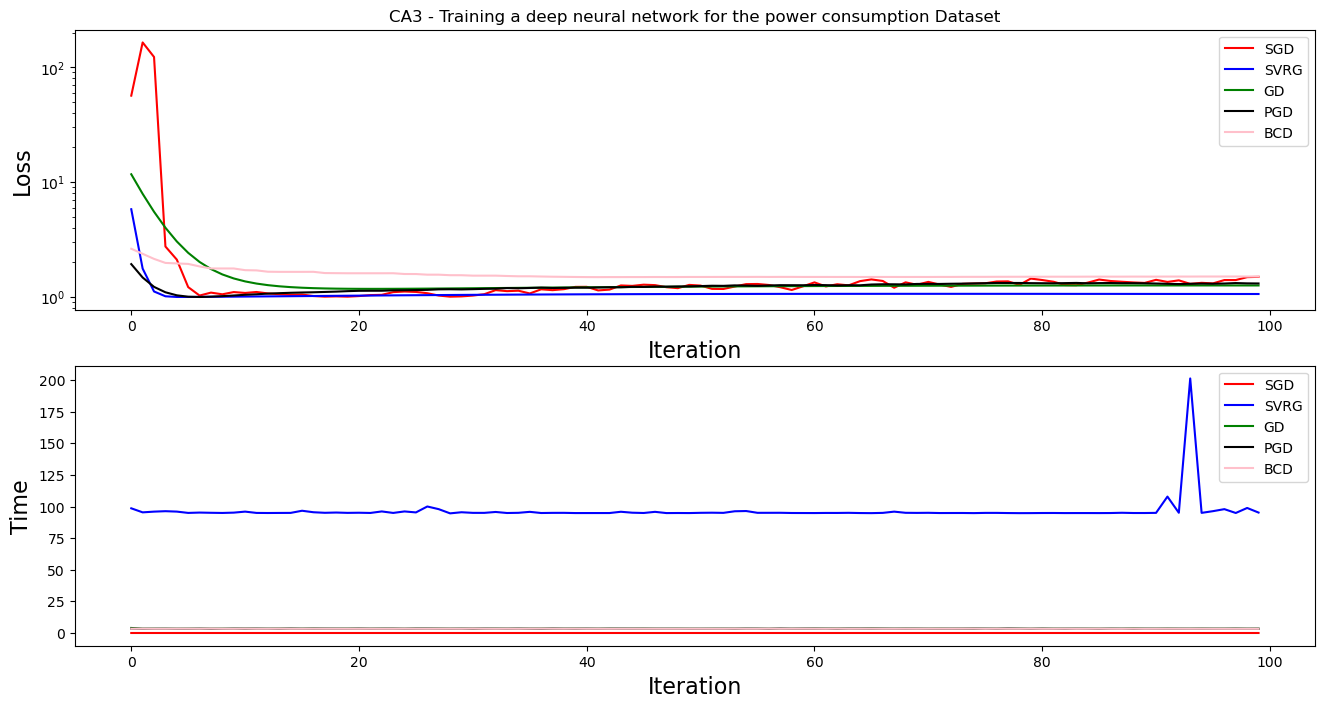

<Figure size 640x480 with 0 Axes>

In [83]:
# Plot results
# Define plotting variables
fig, ax = plt.subplots(2, 1, figsize=(16, 8))
ax[0].legend(loc="upper right")
ax[0].set_xlabel(r"Iteration", fontsize=16)
ax[0].set_ylabel("Loss", fontsize=16)
ax[0].set_title("CA3 - Training a deep neural network for the power consumption Dataset")
#ax[0].set_ylim(ymin=0)
ax[0].set_yscale('log')
ax[0].plot(loss_[:,0], color="red")
ax[0].plot(loss_[:,1], color="blue")
ax[0].plot(loss_[:,2], color="green")
ax[0].plot(loss_[:,3], color="black")
ax[0].plot(loss_[:,4], color="pink")
ax[0].legend(['SGD', 'SVRG', 'GD', 'PGD', 'BCD'])
#plt.show()
#
ax[1].legend(loc="upper right")
ax[1].set_xlabel(r"Iteration", fontsize=16)
ax[1].set_ylabel("Time", fontsize=16)
#ax[1].set_ylim(ymin=50, ymax=100)
#ax[1].set_yscale('log')
ax[1].plot()
ax[1].plot(ti[:,0], color="red")
ax[1].plot(ti[:,1], color="blue")
ax[1].plot(ti[:,2], color="green")
ax[1].plot(ti[:,3], color="black")
ax[1].plot(ti[:,4], color="pink")
ax[1].legend(['SGD', 'SVRG', 'GD', 'PGD', 'BCD'])
plt.show()
plt.savefig("CA3-power.png")

#plt.savefig("power.png")
#plt.savefig("GHG.png")